Importing modules

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

Data Cleaning Pipeline

In [6]:
#insert data pipeline here

Preliminary data analysis: selecting the locations of interest
NB: This data contains the breweries and beers defined by country excluding the US which is further separated by US states

In [ ]:
#number of beers per location
breweries = pd.read_csv('minimizedData/BA_breweries_small.csv')

In [11]:
#Calculating the number of beers and breweries produced by each location
country_stats = breweries.groupby('location').agg(
    total_breweries=('id', 'nunique'),
    total_beers=('nbr_beers', 'sum')
).reset_index()

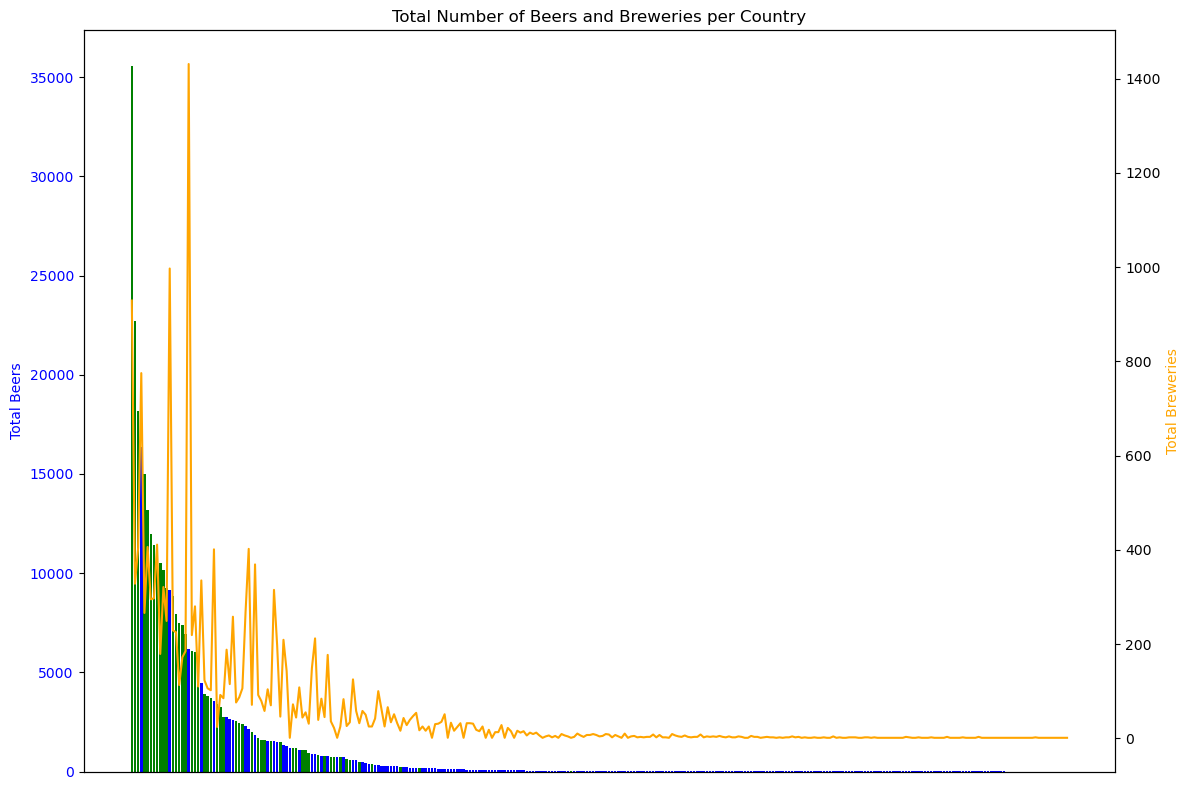

In [ ]:
# Plotting the total number of beers and breweries for each location

country_stats = country_stats.sort_values(by='total_beers', ascending=False)
fig, ax1 = plt.subplots(figsize=(12, 8))

bar_colors = ['green' if country.startswith('United States,') else 'blue' for country in country_stats['location']]

# Bar plot for total beers
ax1.bar(country_stats['location'], country_stats['total_beers'], color=bar_colors, label='Total Beers')
#ax1.set_xlabel('Country')
ax1.set_ylabel('Total Beers', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks([])

#Overlay line plot for total breweries
ax2 = ax1.twinx()
ax2.plot(country_stats['location'], country_stats['total_breweries'], color='orange', label='Total Breweries')
ax2.set_ylabel('Total Breweries', color='orange')
plt.xticks([])

plt.title('Total Number of Beers and Breweries per Location')
fig.tight_layout()
plt.show()


The distribution of users by location of origin

In [ ]:
users = pd.read_csv('minimizedData/BA_users_small.csv')
print("Quick stats on the users")
print("total number of users:", users.shape[0])
#Remove users with unknown locations
users = users.dropna(subset=['location'])
print("Number of users with known locations:", users.shape[0])
print("Users originate from: ",users['location'].dropna().nunique() , "different locations")

   Unnamed: 0  nbr_ratings                user_id                   location
0           0         7820         nmann08.184925  United States, Washington
1           1         2521     stjamesgate.163714    United States, New York
2           2         1797          mdagnew.19527           Northern Ireland
3           3           31  helloloser12345.10867           Northern Ireland
4           4          604        cypressbob.3708           Northern Ireland
Quick stats on the users
total number of users: 153704
Number of users with known locations: 122425
Users originate from:  194 different locations


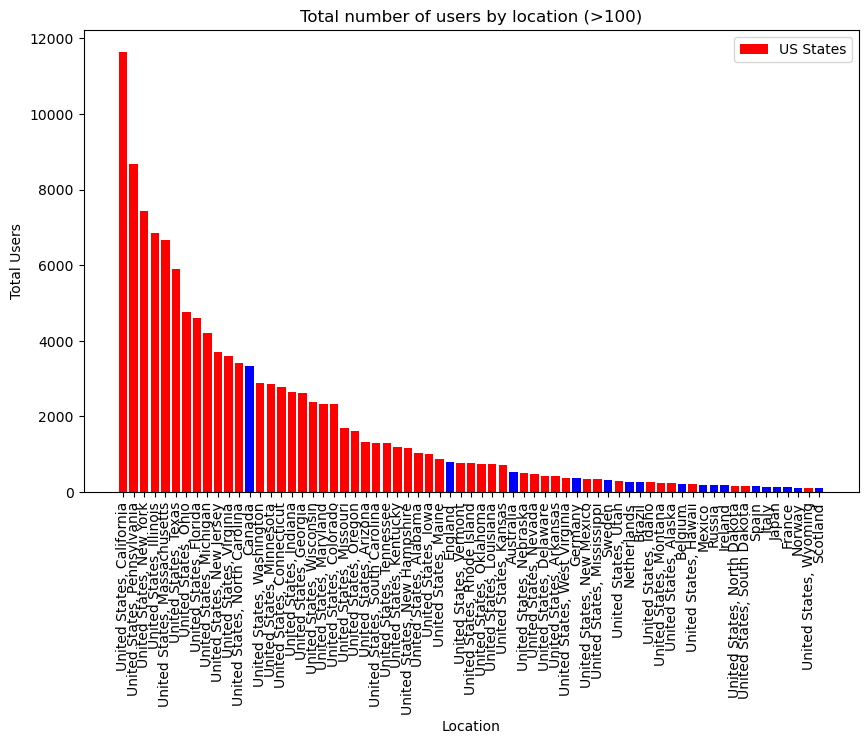

In [23]:
#plotting user location distributions
user_counts = users.groupby('location').size().reset_index(name='total_users')
user_counts = user_counts[user_counts['total_users'] >= 100]
user_counts = user_counts.sort_values(by='total_users', ascending=False)
user_counts['color'] = user_counts['location'].apply(lambda x: 'red' if x.startswith('United States,') else 'blue')
plt.figure(figsize=(10, 6))
plt.bar(user_counts['location'], user_counts['total_users'], color=user_counts['color'], )
plt.xlabel('Location')
plt.ylabel('Total Users')

plt.legend(['US States'], loc="upper right")
plt.title('Total number of users by location (>100)')
plt.xticks(rotation=90)

plt.show()


In [28]:
#Remove ratings where user_location and beer location is missing (NaN)
#HERE WE WILL remove to refer to the cleaned data from the pipeline!!!
BA_merged = pd.read_csv('minimizedData/BA_ratings_small_plus.csv')
BA_merged_cleaned = BA_merged[BA_merged['user_location'].notna()]
BA_merged_cleaned = BA_merged[BA_merged['beer_location'].notna()]

#Local reviews (reviews written by people from one country reviewing beers from that same location)
local_reviews = BA_merged_cleaned[BA_merged_cleaned['user_location'] == BA_merged_cleaned['beer_location']].groupby('beer_location').size().reset_index(name='local_reviews')

#Non-local reviews (reviews written by people for beers from other location)
non_local_reviews = BA_merged_cleaned[BA_merged_cleaned['user_location'] != BA_merged_cleaned['beer_location']].groupby('beer_location').size().reset_index(name='non_local_reviews')

#Total number of beers per country from the 'country_stats' DataFrame
country_stats = breweries.groupby('location').agg(
    total_breweries=('id', 'nunique'),  # Count of unique breweries per country
    total_beers=('nbr_beers', 'sum')  # Sum of beers per country
).reset_index()

#Merge the dataframes
country_data = pd.merge(country_stats, local_reviews, left_on='location', right_on='beer_location', how='left')
country_data = pd.merge(country_data, non_local_reviews, left_on='location', right_on='beer_location', how='left')

#Fill NaN values with 0 for countries with no reviews in any category
country_data[['local_reviews', 'non_local_reviews']] = country_data[['local_reviews', 'non_local_reviews']].fillna(0)

#Sort the DataFrame by the total number of local reviews in ascending order
country_data = country_data.sort_values(by='local_reviews', ascending=False)




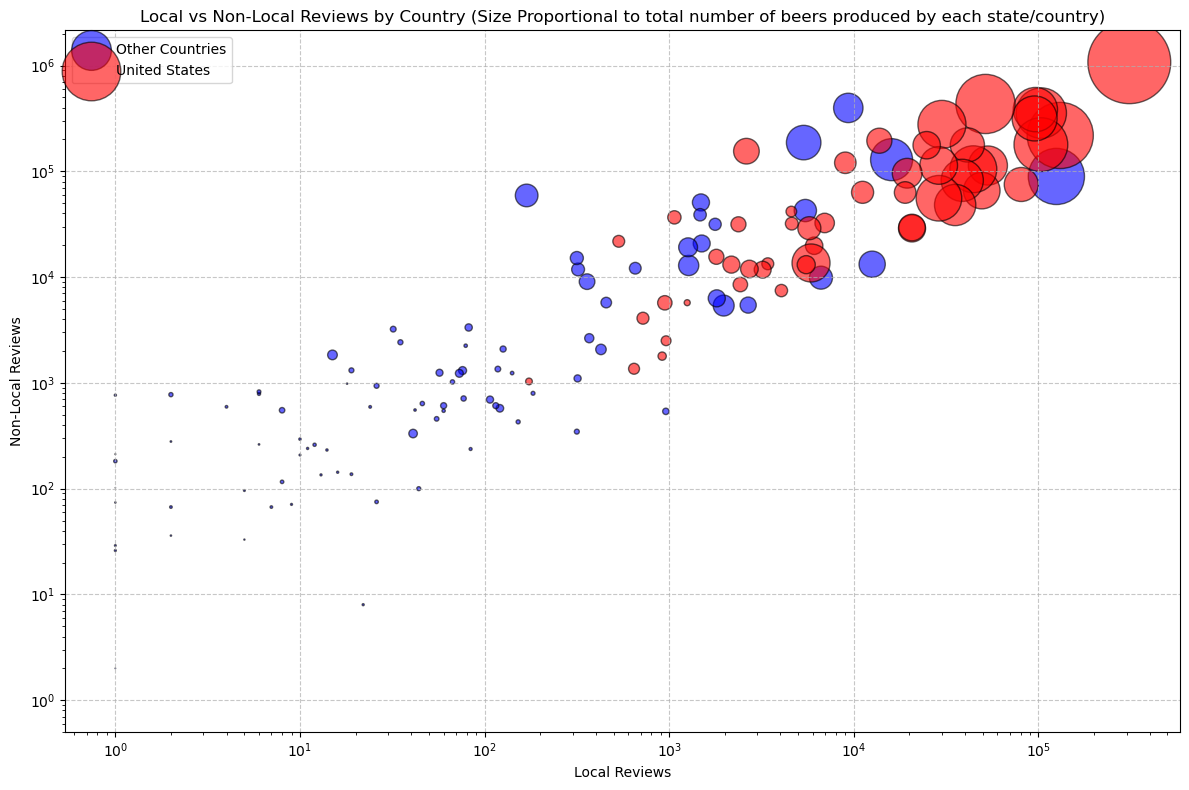

In [30]:

fig, ax = plt.subplots(figsize=(12, 8))

#Identify states that are in the US
highlighted = country_data['location'].str.startswith('United States')

#Plot for countries that are NOT 'United States' in blue
scatter = ax.scatter(
    country_data.loc[~highlighted, 'local_reviews'],
    country_data.loc[~highlighted, 'non_local_reviews'],
    s=country_data.loc[~highlighted, 'total_beers'] * 0.1,
    color='blue', 
    alpha=0.6,
    edgecolor='black',
    label='Other Countries'
)

#Plot for US states in red
scatter_us = ax.scatter(
    country_data.loc[highlighted, 'local_reviews'],
    country_data.loc[highlighted, 'non_local_reviews'],
    s=country_data.loc[highlighted, 'total_beers'] * 0.1,
    color='red',
    alpha=0.6,
    edgecolor='black',
    label='United States'
)

# Set plot labels and title
ax.set_xlabel('Local Reviews')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Non-Local Reviews')
ax.set_title('Local vs Non-Local Reviews by Country (Size Proportional to total number of beers produced by each state/country)')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


The number of beers produced by each b